### CREATING PLAYER DATASET BY ANALYSING THE PERFORMANCE OF EACH PLAYER

In [56]:
%matplotlib inline
import matplotlib.pyplot  as plt
import pandas as pd

In [57]:

balldf = pd.read_csv("IPL_Ball_by_Ball_2008_2021.csv")


In [58]:
matchdf = pd.read_csv("IPL_Matches_2008_2021.csv")

In [59]:
balldf.isna().sum()

ID                        0
innings                   0
overs                     0
ballnumber                0
batter                    0
bowler                    0
non-striker               0
extra_type           197043
batsman_run               0
extras_run                0
total_run                 0
non_boundary              0
isWicketDelivery          0
player_out           197803
kind                 197803
fielders_involved    200758
BattingTeam               0
dtype: int64

In [60]:
matchdf.isna().sum()

ID                   0
City                51
Date                 0
Season               0
MatchNumber          0
Team1                0
Team2                0
Venue                0
TossWinner           0
TossDecision         0
SuperOver            4
WinningTeam          4
WonBy                0
Margin              18
method             857
Player_of_Match      4
Team1Players         0
Team2Players         0
Umpire1              0
Umpire2              0
dtype: int64

In [61]:
# Group details on batsmen
batgroup = balldf.groupby(['batter'])

# Create a batting dataframe with a summary statistics for each batsman
batdf = pd.DataFrame(batgroup['ballnumber'].count()).rename(columns={'ballnumber':'balls_faced'})
batdf['innings'] = batgroup['ID'].nunique()
batdf['runs'] = batgroup['batsman_run'].sum()
batdf['4s'] = balldf[balldf['batsman_run'] == 4].groupby('batter')['batsman_run'].count()
batdf['4s'].fillna(0,inplace=True)
batdf['6s'] = balldf[balldf['batsman_run'] == 6].groupby('batter')['batsman_run'].count()
batdf['6s'].fillna(0,inplace=True)

In [62]:
# Batting average = total rus scored/no. of times batsman is been dismissed
# Approximated here to matches instead of no. of dismissals
batdf['bat_average'] = round(batdf['runs']/batdf['innings'],2)

In [63]:
# Strike Rate = (Runs Scored / Balls faced) * 100
batdf['bat_strike'] = round(batdf['runs']/batdf['balls_faced']*100,2)

In [64]:
display(batdf.head())

,balls_faced,innings,runs,4s,6s,bat_average,bat_strike
batter,,,,,,,
A Ashish Reddy,196,23,280,16.0,15.0,12.17,142.86
A Chandila,7,2,4,0.0,0.0,2.00,57.14
A Chopra,75,6,53,7.0,0.0,8.83,70.67
A Choudhary,20,3,25,1.0,1.0,8.33,125.00
A Dananjaya,5,1,4,0.0,0.0,4.00,80.00


In [65]:
balldf['kind'].unique()

array([nan, 'caught', 'lbw', 'bowled', 'run out', 'caught and bowled',
       'stumped', 'retired hurt', 'hit wicket', 'obstructing the field'],
      dtype=object)

In [66]:
# Group details on bowler
bowlgroup = balldf.groupby(['bowler'])

# Create a bowling dataframe (bowldf) with a summary statistics for each batsman
bowldf = pd.DataFrame(bowlgroup['ballnumber'].count()).rename(columns={'ballnumber':'balls_bowled'})

# Get no. of wickets taken by each bowler
bwl_wkts = balldf[balldf['kind'].isin(['caught','bowled', 'lbw','stumped', 'caught and bowled', 'hit wicket'])]
bowldf['wickets'] = bwl_wkts.groupby(['bowler'])['ballnumber'].count()
bowldf['wickets'].fillna(0,inplace=True)
 
# Calculate the total no. of overs bowled
overs = pd.DataFrame(balldf.groupby(['bowler','ID'])['overs'].nunique())
bowldf['overs'] = overs.groupby(['bowler'])['overs'].sum()    

# Calculate the runs conceded
bowldf['runs_conceded'] = balldf.groupby('bowler')['batsman_run'].sum()
bowldf['runs_conceded'] = bowldf['runs_conceded'].fillna(0)
# Add the runs conceded through wide and noball
bowldf['runs_conceded'] = bowldf['runs_conceded'].add(balldf[balldf['extra_type'].isin(['wides','noballs'])].groupby('bowler')['extras_run'].sum(),fill_value=0)

bowldf.head()





,balls_bowled,wickets,overs,runs_conceded
bowler,,,,
A Ashish Reddy,270,18.0,45,396.0
A Chandila,234,11.0,39,242.0
A Choudhary,108,5.0,17,144.0
A Dananjaya,25,0.0,4,47.0
A Flintoff,66,2.0,11,105.0


In [67]:
# Note - roughly apprx to overs.  Should be runs_conceded/overs.balls
bowldf['bowl_econ'] = round(bowldf['runs_conceded']/bowldf['overs'],2)

In [68]:

display(bowldf.tail())

,balls_bowled,wickets,overs,runs_conceded,bowl_econ
bowler,,,,,
YA Abdulla,222,15.0,35,307.0,8.77
YK Pathan,1184,42.0,193,1415.0,7.33
YS Chahal,2511,139.0,412,3097.0,7.52
Yuvraj Singh,882,36.0,146,1077.0,7.38
Z Khan,2276,102.0,371,2782.0,7.50


In [69]:
# Add each player to the final all players list
def update_player_with_match(player_name, id):
    if player_name in all_players_dict:
        all_players_dict[player_name].add(id)
    else:
        all_players_dict[player_name] = {id}

# Consider players listed as batsman, non striker or bowler
def update_player_list(x):
    update_player_with_match(x['batter'],x['ID'])
    update_player_with_match(x['non-striker'],x['ID'])
    update_player_with_match(x['bowler'],x['ID']) 

In [70]:
# Create a dataframe with all players list
all_players_dict = {}
out_temp = balldf.apply(lambda x: update_player_list(x),axis=1)
all_df = pd.DataFrame({'Players':list(all_players_dict.keys())})
all_df['matches'] = all_df['Players'].apply(lambda x: len(all_players_dict[x]))
all_df=all_df.set_index('Players')

In [71]:
# Combine the batting and bowling dataframes to create a merged players dataframe
players = pd.merge(all_df,batdf, left_index=True, right_index=True,how='outer')
players = pd.merge(players,bowldf, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

In [72]:
players.tail()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ
YV Takawale,10,183.0,10.0,192.0,26.0,3.0,19.20,104.92,0.0,0.0,0.0,0.0,0.00
Yashpal Singh,4,67.0,4.0,47.0,5.0,0.0,11.75,70.15,0.0,0.0,0.0,0.0,0.00
Younis Khan,1,7.0,1.0,3.0,0.0,0.0,3.00,42.86,0.0,0.0,0.0,0.0,0.00
Yuvraj Singh,129,2207.0,126.0,2754.0,218.0,149.0,21.86,124.78,882.0,36.0,146.0,1077.0,7.38
Z Khan,99,141.0,27.0,117.0,11.0,2.0,4.33,82.98,2276.0,102.0,371.0,2782.0,7.50



Create no. of catches statistics

In [73]:
# Total catches = Number of caught & bowled + number of catches as fielder
# Capture caught & bowled instances
catches_cb = balldf[(balldf['kind'].isin(['caught and bowled']))].groupby('bowler')['ballnumber'].count().rename('bowler_catches')
# Capture the catches
catches_c = balldf[(balldf['kind'].isin(['caught']))].groupby('fielders_involved')['ballnumber'].count().rename('fielder_catches')
# Combine the caught & bowled and fielding catches to get the total catches.
catches_df = pd.merge(catches_cb,catches_c, left_index=True, right_index=True,how='outer')
catches_df.fillna(0,inplace=True)
catches_df['catches'] = catches_df['bowler_catches']+catches_df['fielder_catches']
catches_df.drop(['bowler_catches','fielder_catches'],axis=1,inplace=True)
# Merge total catches to players data
players = pd.merge(players,catches_df, left_index=True, right_index=True,how='outer')
players.fillna(0,inplace=True)

In [74]:
# Number of man of the matches from matches file
players = pd.merge(players,matchdf['Player_of_Match'].value_counts(), left_index=True, right_index=True,how='left')
players['Player_of_Match']  = players[['Player_of_Match']].fillna(0)

In [75]:
players.head()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,Player_of_Match
A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Chandila,12.0,7.0,2.0,4.0,0.0,0.0,2.00,57.14,234.0,11.0,39.0,242.0,6.21,7.0,1.0
A Chopra,6.0,75.0,6.0,53.0,7.0,0.0,8.83,70.67,0.0,0.0,0.0,0.0,0.00,2.0,0.0
A Choudhary,5.0,20.0,3.0,25.0,1.0,1.0,8.33,125.00,108.0,5.0,17.0,144.0,8.47,0.0,0.0
A Dananjaya,1.0,5.0,1.0,4.0,0.0,0.0,4.00,80.00,25.0,0.0,4.0,47.0,11.75,0.0,0.0


In [76]:
players.shape

(614, 15)

Filtering: Remove players who have played less matches

In [77]:
# Backup before data filtering
all_players = players.copy()

ALL_COLUMN_NAMES = list(players.columns)

In [78]:
players.shape

(614, 15)

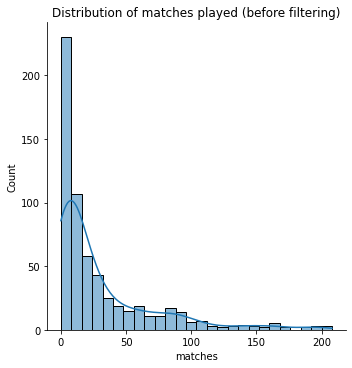

In [79]:
import seaborn as sns
sns.displot(players['matches'],kde=True)
plt.title('Distribution of matches played (before filtering)')
plt.show()

In [80]:
players['matches'].describe()

count    614.000000
mean      30.096091
std       40.213568
min        0.000000
25%        4.000000
50%       13.000000
75%       38.000000
max      208.000000
Name: matches, dtype: float64

In [81]:
# Cut off on no. of matches

# Current Analysis: Players who have played atleast 10 matches
CUTOFF_MATCHES = 10
players=players[players['matches']>=CUTOFF_MATCHES]

In [82]:
players.shape

(349, 15)

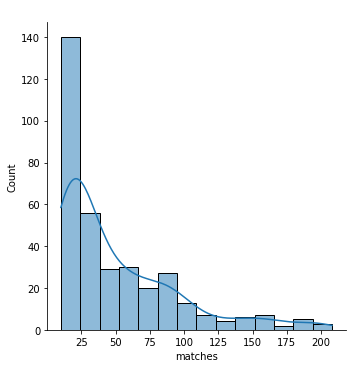

In [83]:
sns.displot(players['matches'],kde=True)
plt.title('Distribution of matches played (after filtering)',color="white")
plt.show()

In [84]:
players['matches'].describe()

count    349.000000
mean      49.971347
std       43.881296
min       10.000000
25%       18.000000
50%       32.000000
75%       71.000000
max      208.000000
Name: matches, dtype: float64

Explore the players data

In [85]:
players.head()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,Player_of_Match
A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Chandila,12.0,7.0,2.0,4.0,0.0,0.0,2.00,57.14,234.0,11.0,39.0,242.0,6.21,7.0,1.0
A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0
A Mishra,154.0,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3317.0,166.0,543.0,3976.0,7.32,21.0,12.0
A Mithun,16.0,26.0,6.0,34.0,4.0,1.0,5.67,130.77,312.0,7.0,48.0,472.0,9.83,7.0,0.0


In [86]:
players.shape

(349, 15)

In [87]:
players.to_csv("Players.csv")

<function matplotlib.pyplot.show(close=None, block=None)>

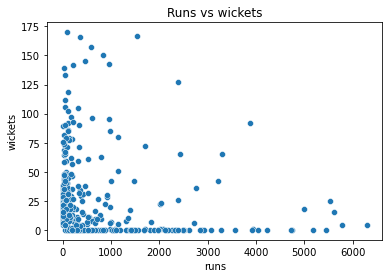

In [88]:
sns.scatterplot(data=players, x="runs", y="wickets")
plt.title("Runs vs wickets")
plt.show

In [89]:
players.columns

Index(['matches', 'balls_faced', 'innings', 'runs', '4s', '6s', 'bat_average',
       'bat_strike', 'balls_bowled', 'wickets', 'overs', 'runs_conceded',
       'bowl_econ', 'catches', 'Player_of_Match'],
      dtype='object')

Scale the data

In [90]:
# Standard Scaler (mean = 0 and standard deviation = 1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# fit_transform
players_scaled = pd.DataFrame(scaler.fit_transform(players),columns=players.columns)
players_scaled.shape
players_scaled.head()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,Player_of_Match
0,-0.501418,-0.428133,-0.302289,-0.382756,-0.454650,-0.255442,-0.132351,1.141815,-0.397186,-0.209201,-0.386785,-0.351007,0.680580,-0.414252,-0.658866
1,-0.866562,-0.641498,-0.808569,-0.624030,-0.602244,-0.575662,-1.213820,-1.661977,-0.446219,-0.412656,-0.437085,-0.520762,-0.024946,-0.510602,-0.390239
2,-0.181918,-0.594083,-0.495158,-0.596930,-0.574570,-0.575662,-1.178728,-1.194570,0.573942,0.575553,0.602446,0.378719,0.051327,-0.366076,0.147013
3,2.374087,-0.186546,0.445076,-0.311073,-0.334730,-0.468922,-0.714026,-0.643100,3.752922,4.092413,3.788104,3.595248,0.277423,0.163851,2.564650
4,-0.775276,-0.620048,-0.712135,-0.597804,-0.565345,-0.554314,-0.823555,0.746366,-0.339981,-0.528916,-0.361635,-0.267232,0.961156,-0.510602,-0.658866


In [91]:
# Mean around ~0 and standard deviation ~1 in all the scaled columns
players_scaled.describe()

,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,Player_of_Match
count,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02,3.490000e+02
mean,-3.244778e-17,1.399708e-17,9.813863e-17,-6.680425e-17,-7.889264e-17,1.463331e-17,1.695556e-16,-1.790990e-16,4.071878e-17,6.362310e-18,2.926662e-17,3.053909e-17,-1.608074e-16,-7.722253e-17,-2.147279e-17
std,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00,1.001436e+00
min,-9.122050e-01,-6.494001e-01,-8.567862e-01,-6.275263e-01,-6.022436e-01,-5.756623e-01,-1.426498e+00,-3.530954e+00,-7.649345e-01,-7.323703e-01,-7.640345e-01,-7.875201e-01,-1.716573e+00,-8.478286e-01,-6.588656e-01
25%,-7.296332e-01,-5.827942e-01,-6.157007e-01,-5.820689e-01,-5.653451e-01,-5.543143e-01,-8.735348e-01,-4.262416e-01,-7.567624e-01,-7.323703e-01,-7.556512e-01,-7.709855e-01,5.018786e-03,-6.069525e-01,-6.588656e-01
50%,-4.101326e-01,-4.439379e-01,-3.987237e-01,-4.483193e-01,-4.454250e-01,-4.048782e-01,-8.556186e-02,2.181203e-01,-3.835659e-01,-3.835908e-01,-3.784021e-01,-3.796670e-01,3.754879e-01,-3.179012e-01,-3.902393e-01
75%,4.799048e-01,1.408392e-01,3.245329e-01,1.452492e-01,9.882769e-02,1.074741e-01,7.534539e-01,6.446421e-01,3.042598e-01,2.267733e-01,2.922629e-01,3.324226e-01,5.852388e-01,1.638510e-01,1.470132e-01
max,3.606446e+00,4.950010e+00,4.133684e+00,4.873691e+00,5.430659e+00,7.088274e+00,2.676065e+00,2.228726e+00,4.145187e+00,4.208672e+00,4.140204e+00,3.953497e+00,3.731502e+00,5.222249e+00,6.056791e+00


update player name as column

In [92]:
players.insert(0, 'name', players.index)

In [93]:
players.head()

,name,matches,balls_faced,innings,runs,4s,6s,bat_average,bat_strike,balls_bowled,wickets,overs,runs_conceded,bowl_econ,catches,Player_of_Match
A Ashish Reddy,A Ashish Reddy,28.0,196.0,23.0,280.0,16.0,15.0,12.17,142.86,270.0,18.0,45.0,396.0,8.80,9.0,0.0
A Chandila,A Chandila,12.0,7.0,2.0,4.0,0.0,0.0,2.00,57.14,234.0,11.0,39.0,242.0,6.21,7.0,1.0
A Kumble,A Kumble,42.0,49.0,15.0,35.0,3.0,0.0,2.33,71.43,983.0,45.0,163.0,1058.0,6.49,10.0,3.0
A Mishra,A Mishra,154.0,410.0,54.0,362.0,29.0,5.0,6.70,88.29,3317.0,166.0,543.0,3976.0,7.32,21.0,12.0
A Mithun,A Mithun,16.0,26.0,6.0,34.0,4.0,1.0,5.67,130.77,312.0,7.0,48.0,472.0,9.83,7.0,0.0


<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
CLUSTERING
</h1>

In [94]:
# Initialize few colour codes for each cluster
CLUSTER_COLORS = ['#D6FFF6','#F7D6E0','#4DCCBD','#2374AB','#FF8484','#C64191','#086788','#231651',
                  '#36688D','#00743F','#0444BF','#A7414A','#1D65A6','red','green','blue','orange','pink','yellow']


In [95]:
# Show the top few players in each cluster (Players sorted on no. of matches played)
def  groupby_cluster(cluster_col, head_size):
    g = players.groupby([cluster_col]).apply(lambda x: x.sort_values(["matches"], ascending = False)).reset_index(drop=True)
    # select top N rows within each cluster
    display(g.groupby(cluster_col)['name',cluster_col].head(head_size))


In [96]:
def print_with_column_color_style(input_df):

    col_bgcolor_dict = dict(zip(input_df.columns,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return pd.DataFrame(col_bgcolor_dict,index=x.index,columns=x.columns)

    return input_df.style.apply(mycolor,axis=None)

In [97]:
def print_with_row_color_style(input_df, cluster_col):
    clusters = list(input_df[cluster_col].sort_values().unique())
    col_bgcolor_dict = dict(zip(clusters,['background-color:'+i for i in CLUSTER_COLORS]))
    def mycolor(x):
        return [col_bgcolor_dict[x[cluster_col]]]*len(x)
    
    return input_df.style.apply(mycolor,axis=1)

In [98]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_summary(cluster_col):
    
    # Create summary table for clusters
    cluster_summary = pd.DataFrame(players[cluster_col].value_counts().sort_index())
    cluster_summary.columns = ['Num_Players']
    cluster_summary.insert(0, 'Cluster', cluster_summary.index)
    
    # Plot pie-chart
    fig = plt.figure(figsize=(15,6))

    ax1 = fig.add_subplot(121)
    cluster_summary['Num_Players'].plot.pie(autopct="%1.1f%%",  colors = CLUSTER_COLORS)
    
    print("\n-----------------------\nPLAYERS CLUSTER SUMMARY\n-----------------------\n")
    
    # Plot summary table

    #display(cluster_summary)
    ax2 = fig.add_subplot(122)
    font_size=14
    bbox=[0, 0, 1, 1]
    ax2.axis('off')
    
    # Set the row colours to match the cluster index
    colors = []
    num_columns = len(cluster_summary.columns)
    num_rows = len(cluster_summary.index)
    for i in range(num_rows):
        colors.append([CLUSTER_COLORS[i]] * num_columns)

    summary_plot_table = ax2.table(cellText=cluster_summary.values,cellColours=colors,
                         colLabels=cluster_summary.columns,bbox=bbox,loc='center',cellLoc='center' )

    summary_plot_table.auto_set_font_size(False)
    summary_plot_table.set_fontsize(font_size)

    plt.show()


In [99]:
# Get the summary of the clustering based on the labels in the output column specified
def  clustering_data(cluster_col):
    grouper = players.sort_values(["innings"], ascending = False)[['name',cluster_col]].groupby([cluster_col])
    cluster_df = pd.concat([pd.Series(v['name'].tolist(), name=k) for k, v in grouper], axis=1)
    cluster_df.fillna('',inplace=True)
    print("\n-----------------------\nPLAYERS IN EACH CLUSTER\n-----------------------\n")
    display(print_with_column_color_style(cluster_df))
    
    #return cluster_summary, cluster_df

In [100]:
# Get the summary of the clustering based on the labels in the output column specified
def  cluster_all_stats(cluster_col): 
    display(print_with_row_color_style(players[CLUSTER_COLS+[cluster_col]],cluster_col))
    

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
HEIRARCHICAL CLUSTERING 
</h1>

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
AGNES
</h1>

In [101]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity

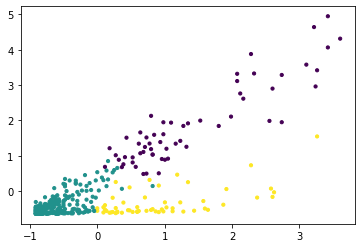

In [102]:
X=players_scaled[ALL_COLUMN_NAMES].values
agg_clust = AgglomerativeClustering(n_clusters=3)
assigned_clust = agg_clust.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=assigned_clust, s=10);

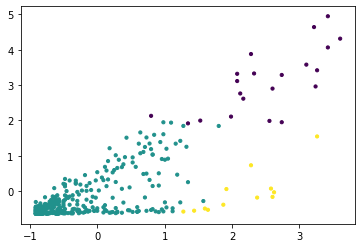

In [103]:
agg_avg = AgglomerativeClustering(linkage ='average', n_clusters=3)
as_avg = agg_avg.fit_predict(X)
players["cluster_avg"] = agg_avg.labels_
plt.scatter(X[:, 0], X[:, 1], c=as_avg, s=10);


-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



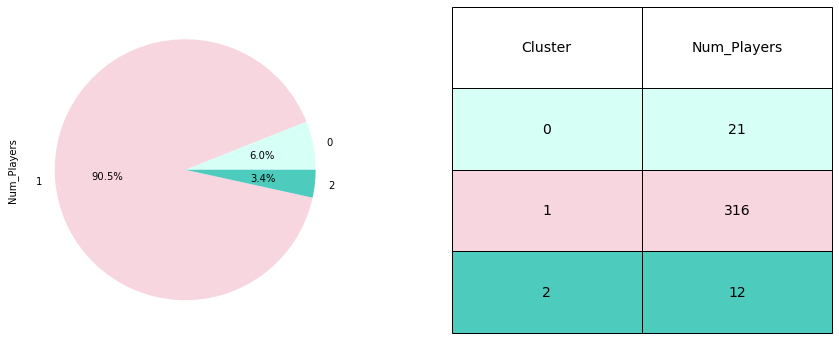

In [104]:
clustering_summary("cluster_avg")

In [105]:
clustering_data("cluster_avg")


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



,0,1,2
0,RG Sharma,Yuvraj Singh,RA Jadeja
1,SK Raina,WP Saha,DJ Bravo
2,V Kohli,M Vijay,Harbhajan Singh
3,MS Dhoni,V Sehwag,PP Chawla
4,KD Karthik,SA Yadav,SP Narine
5,S Dhawan,MA Agarwal,R Ashwin
6,RV Uthappa,JH Kallis,A Mishra
7,AB de Villiers,NV Ojha,B Kumar
8,AT Rayudu,F du Plessis,UT Yadav
9,KA Pollard,SPD Smith,SL Malinga


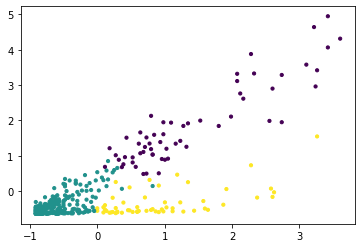

In [106]:
agg_ward = AgglomerativeClustering(linkage ='ward', n_clusters=3)
as_ward = agg_ward.fit_predict(X)
players["cluster_ward"] = agg_ward.labels_
plt.scatter(X[:, 0], X[:, 1], c = as_ward, s = 10);


-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



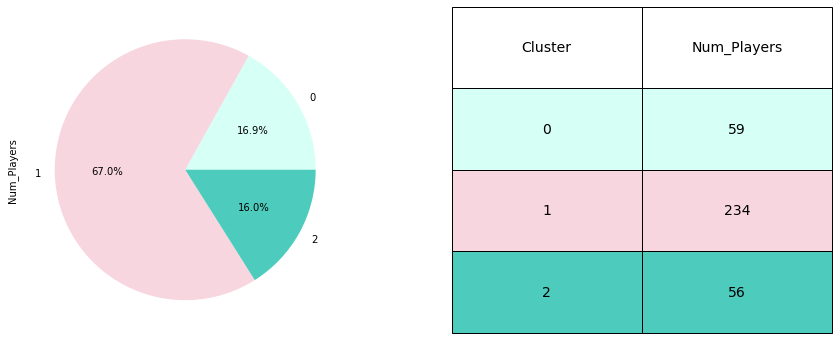

In [107]:
clustering_summary("cluster_ward")

In [108]:
clustering_data("cluster_ward")


-----------------------
PLAYERS IN EACH CLUSTER
-----------------------



,0,1,2
0,RG Sharma,STR Binny,RA Jadeja
1,SK Raina,BJ Hodge,DJ Bravo
2,V Kohli,DJ Hussey,Harbhajan Singh
3,MS Dhoni,DJ Hooda,IK Pathan
4,KD Karthik,RA Tripathi,AR Patel
5,S Dhawan,SC Ganguly,PP Chawla
6,RV Uthappa,Ishan Kishan,SP Narine
7,AB de Villiers,LRPL Taylor,KH Pandya
8,AT Rayudu,PP Shaw,JA Morkel
9,KA Pollard,Y Venugopal Rao,R Ashwin


<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
PERFORMANCE EVALUATION - AGNES CLUSTERING - AVERAGE
</h1>

In [109]:
labels_avg = agg_avg.labels_
print("calinski_harabasz_score:  ",calinski_harabasz_score(X,labels_avg))
print("silhouette_score:  ",silhouette_score(X,labels_avg))
print("davies_bouldin_score:  ",davies_bouldin_score(X,labels_avg))

NameError: name 'calinski_harabasz_score' is not defined

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
PERFORMANCE EVALUATION - AGNES CLUSTERING - WARD
</h1>

In [110]:
labels_ward = agg_ward.labels_
print("calinski_harabasz_score:  ",calinski_harabasz_score(X,labels_ward))
print("silhouette_score:  ",silhouette_score(X,labels_ward))
print("davies_bouldin_score:  ",davies_bouldin_score(X,labels_ward))

NameError: name 'calinski_harabasz_score' is not defined

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
DBSCAN CLUSTERING
</h1>

Estimated number of clusters: 3
Estimated number of noise points: 137

-----------------------
PLAYERS CLUSTER SUMMARY
-----------------------



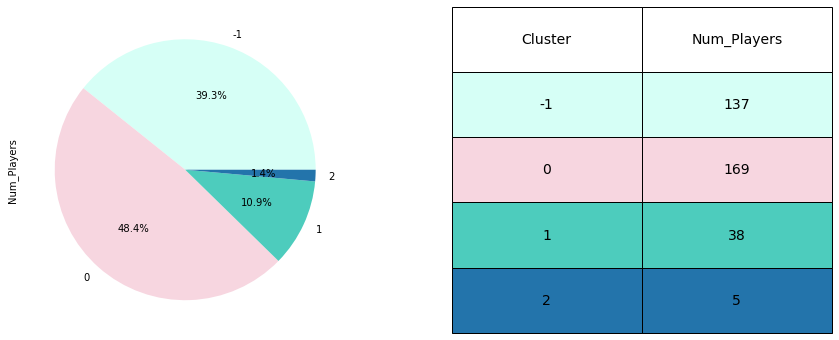

In [111]:
from sklearn.cluster import DBSCAN

# Perform density clustering based on the input parameters
db = DBSCAN(eps=0.9, min_samples=5).fit(players_scaled)

# Assign cluster labels
players["cluster_dbscan"] = db.labels_

# Number of clusters in labels, ignoring noise if present.
labels = db.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

clustering_summary("cluster_dbscan")

In [112]:
clustering_data(dbscan_label)

NameError: name 'dbscan_label' is not defined

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
PERFORMANCE EVALUATION - DBSCAN CLUSTERING
</h1>

In [113]:
X=players_scaled[ALL_COLUMN_NAMES].values
clustering = DBSCAN(eps=0.9, min_samples=5).fit(X)
labels = clustering.labels_
print("Silhouette Coefficient: %0.3f"%silhouette_score(X, labels))
print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X, labels))
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X, labels))
print("---------------------------------------------------------------")

NameError: name 'silhouette_score' is not defined

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
MEAN SHIFT CLUSTERING
</h1>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift 
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
ms = MeanShift()
# cluster_centers = ms.cluster_centers_
def ms_clustering(input_df,output_df, output_col):
    ms = MeanShift()
    ms.fit(input_df)
    output_df[output_col] = ms.labels_ 

#-----------------------------------------------------------------------------------------------------#

ms_label = 'cluster_ms'
ms_clustering(players_scaled[ALL_COLUMN_NAMES],players,ms_label)

groupby_cluster(ms_label,3)
#-----------------------------------------------------------------------------------------------------#

clustering_summary(ms_label)





In [ ]:
ms = MeanShift()
X=players_scaled[ALL_COLUMN_NAMES].values
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], marker='o')
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], 
 cluster_centers[:,2], marker='x', color='red', s=300, linewidth=5,
                                   zorder=10)
plt.show()
# cluster_centers = ms.cluster_centers_
# print(cluster_centers)
n_clusters_ = len(np.unique(labels))
print("Estimated clusters:", n_clusters_)
colors = 10*['r.','g.','b.','c.','k.','y.','m.']
ypred = ms.predict(X)
for i in range(len(X)):
    plt.plot(X[i][0], X[i][1],ypred, colors[labels[i]], markersize = 3)
plt.scatter(cluster_centers[:,0],cluster_centers[:,1],
           marker=".",color='k', s=20, linewidths = 5, zorder=10)
plt.show()

In [ ]:
clustering_data(ms_label)

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
PERFORMANCE EVALUATION - MEAN SHIFT CLUSTERING
</h1>

In [ ]:
X=players_scaled[ALL_COLUMN_NAMES].values
# se = [] 
sil_scores = []
calinski_score = []
davies_score = []
index = range(2, 7)

ms = MeanShift()
labels = ms.fit_predict(X)

sil_scores.append(silhouette_score(X, labels))
calinski_score.append(calinski_harabasz_score(X, labels))
davies_score.append(davies_bouldin_score(X, labels))
 
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X, labels))
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X, labels))
print("---------------------------------------------------------------")

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
MINI BATCH KMEANS CLUSTERING
</h1>

In [ ]:
from sklearn.cluster import MiniBatchKMeans
# Define function to perform the kmeans clustering on the given data
def kmeans_clustering(num_clusters, max_iterations,input_df,output_df, output_col):
    kmeans = MiniBatchKMeans(n_clusters=6, random_state=0, batch_size=6)
    kmeans.fit_predict(input_df)
    # assign the label to the output column
    output_df[output_col] = kmeans.labels_ 

In [ ]:
# New output column to create for the cluster label
kmeans_label = 'cluster_kmeans'

# K-means clustering
kmeans_clustering(5,50,players_scaled[ALL_COLUMN_NAMES],players,kmeans_label)

print(players_scaled[ALL_COLUMN_NAMES])
# View few entries from each cluster
groupby_cluster(kmeans_label,3)

In [ ]:
clustering_summary(kmeans_label)

In [ ]:
clustering_data(kmeans_label)

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
PERFORMANCE EVALUATION - MINI BATCH KMEANS CLUSTERING
</h1>

In [ ]:
X=players_scaled[ALL_COLUMN_NAMES].values
# se = [] 
sil_scores = []
calinski_score = []
davies_score = []
index = range(2, 7)
kmeans = MiniBatchKMeans(n_clusters=6, random_state=0, batch_size=6)
labels = kmeans.fit_predict(X)

sil_scores.append(silhouette_score(X, labels))
calinski_score.append(calinski_harabasz_score(X, labels))
davies_score.append(davies_bouldin_score(X, labels))
 
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X, labels))
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X, labels))
print("---------------------------------------------------------------")

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
BIRCH CLUSTERING
</h1>

In [ ]:
from sklearn.cluster import Birch
# from sklearn.datasets.samples_generator import make_blobs
import matplotlib.pyplot as plt
from numpy import random

random.seed(1)
x=players_scaled[ALL_COLUMN_NAMES].values
plt.scatter(x[:,0], x[:,1])
# plt.show()

bclust=Birch(branching_factor=30, threshold = 2.5).fit(x)
print(bclust)

labels = bclust.predict(x)

plt.scatter(x[:,0], x[:,1], c=labels)
plt.show()

In [ ]:
def bclust_clustering(input_df,output_df, output_col):
    bclust=Birch(branching_factor=30, threshold = 2.5).fit(x)
    output_df[output_col] = bclust.labels_ 

#-----------------------------------------------------------------------------------------------------#

bclust_label = 'cluster_bclust'
bclust_clustering(players_scaled[ALL_COLUMN_NAMES],players,bclust_label)

groupby_cluster(bclust_label,3)


In [ ]:
clustering_summary(bclust_label)

In [ ]:
clustering_data(bclust_label)

<h1 style = "font-family: Snell Roundhand;font-weight: 500;font-size: 30px; font-style: normal; background-color: #000000; color :white;"> 
PERFORMANCE EVALUATION - BIRCH CLUSTERING
</h1>

In [ ]:
X=players_scaled[ALL_COLUMN_NAMES].values
# se = [] 
sil_scores = []
calinski_score = []
davies_score = []
index = range(2, 7)

bclust=Birch(branching_factor=30, threshold = 2.5).fit(x)
labels = bclust.labels_

sil_scores.append(silhouette_score(X, labels))
calinski_score.append(calinski_harabasz_score(X, labels))
davies_score.append(davies_bouldin_score(X, labels))
 
print("Silhouette Coefficient: %0.3f" % silhouette_score(X, labels))
print("Calinski-Harabasz Index: %0.3f" % calinski_harabasz_score(X, labels))
print("Davies-Bouldin Index: %0.3f" % davies_bouldin_score(X, labels))
print("---------------------------------------------------------------")